<a href="https://colab.research.google.com/github/weihanchen/google-colab-python-learn/blob/main/jupyter-examples/huggingface/huggingface_text2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 【Hugging Face】Ep.7 以文生圖的魔幻製圖師(Text To Image)

我們過往介紹了幾個關於文字AI應用的篇章：

- [【Hugging Face】Ep.5 文字世界中的超能力語言英雄(Named Entity Recognition)](https://vocus.cc/article/64a42269fd89780001589eca)
- [【Hugging Face】Ep.6 解決問題的專業級破關知識家(Question Answering)](https://vocus.cc/article/64ad426cfd89780001f0f010)

但單獨的文字應用似乎不太能滿足千變萬化的應用時代，相信常常我們都有在Line、Facebook看到過梗圖吧！ 但這些梗圖都非常的陽春，通常在我們給予的背景圖上加註文字，就產生很多的問候圖，非常的呆板，那如果AI能夠理解我們的意圖並繪製出圖片不就更完美了嗎？ 很幸運的我們搭上了AI發展的時代列車，這樣的技術也越趨成熟，各式各樣的模型也都有高手經過微調放置在網路上開源共享，這個篇章我們就會實際以技術角度來進行使用，並測試看看效果如何。

## 我們需要哪些素材？

由於目前效果最好的莫過於「stable-diffusion」了，它是2022年發布的深度學習文字到圖像生成模型， 因此我們也會以它來進行任務，但此模型對於「中文」的識別來說並不友善 😔 ， 那我們能怎麼做呢？

當然可以對該模型進行Fine Tune， But…數據哪裡來？

除了自行Fine Tune之外還有別的思路嗎？ 當然有！ 我們在「[【Hugging Face】Ep.2 初探新手村, 打造專屬的翻譯官](https://vocus.cc/article/64a013ecfd89780001601391)」有介紹了如何搭建一個翻譯官， 那這位翻譯官不就能夠幫助我們將中文翻譯成中文了嗎？ 透過簡單的AI工具庫組合技巧就能夠幫我們完成中文語句產生圖像的任務了， 如此一來需要的素材大致如下：

- 翻譯AI: [Helsinki-NLP/opus-mt-zh-en](https://huggingface.co/Helsinki-NLP/opus-mt-zh-en)
- 文字生成圖片AI: [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)

怎麼找這些模型呢？

在「[【Hugging Face】Ep.3 前往Dataset掏金趣](https://vocus.cc/article/64a2c62afd897800018a8185)」我們有介紹過HuggingFace平台如何精準的找出我們需要的模型。

## 安裝套件

In [ ]:
!pip install diffusers
!pip install transformers
!pip install sentencepiece

!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 46.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=228880c874e8785058dfee845300b9260204986787193de812129a2451c800ec
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


## 尚未經過翻譯翻譯過的結果

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

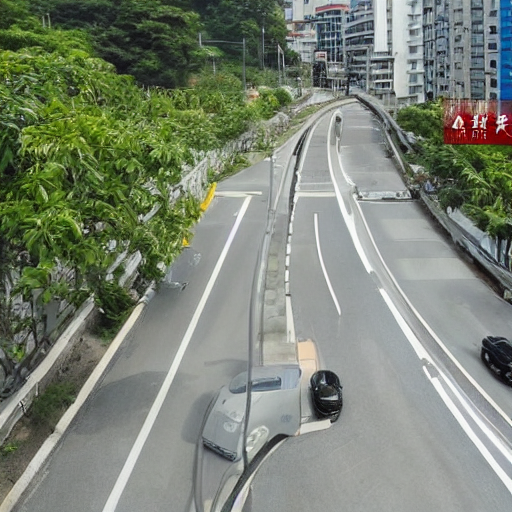

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

t2i = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5')
t2i = t2i.to("cpu")

prompt = "一個在窗戶上的蘋果"
image = t2i(prompt).images[0]
image

我們期望有蘋果、有窗， But…怎麼會是這樣呢？ 這是什麼鬼?

仔細看了官方說明文件有指出: 「該模型主要使用英文字幕進行訓練，在其他語言中效果不佳。」

## 透過翻譯讓AI更理解我們的需求

我們就在產生圖片之前加掛翻譯功能， 將我們的中文語句翻譯成英文， 再讓Text-to-Image AI理解我們真正的意圖。

### 翻譯

透過翻譯， 讓我們將中文轉換成英文

In [ ]:
from transformers import pipeline
# 使用翻譯任務
translator = pipeline("translation", model='Helsinki-NLP/opus-mt-zh-en')

t = translator('一個在窗戶上的蘋果')
prompt = t[0]['translation_text']

### 重新生成圖片

  0%|          | 0/50 [00:00<?, ?it/s]

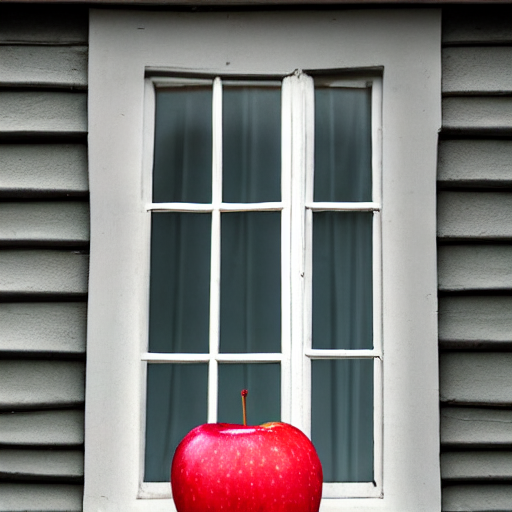

In [ ]:
image = t2i(prompt).images[0]
image